In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras import activations
import matplotlib.pyplot as plt

In [2]:
data = yf.download(tickers='BTC-USD', start="2023-01-01", end="2023-06-10", interval = '1h')['Close']
#print(data)

[*********************100%***********************]  1 of 1 completed


In [3]:
# data pre-processing

scaler = MinMaxScaler()
close_price = data.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)


SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [4]:
# the LSTM model


DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(tf.keras.layers.Activation('linear'))

#   TRAINING

BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/5
49/49 [==============================] - 25s 443ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 2/5
49/49 [==============================] - 21s 420ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 3/5
49/49 [==============================] - 21s 421ms/step - loss: 0.0030 - val_loss: 6.2794e-04
Epoch 4/5
49/49 [==============================] - 21s 423ms/step - loss: 0.0036 - val_loss: 4.6903e-04
Epoch 5/5
49/49 [==============================] - 21s 423ms/step - loss: 0.0043 - val_loss: 0.0013


6/6 [==============================] - 1s 86ms/step


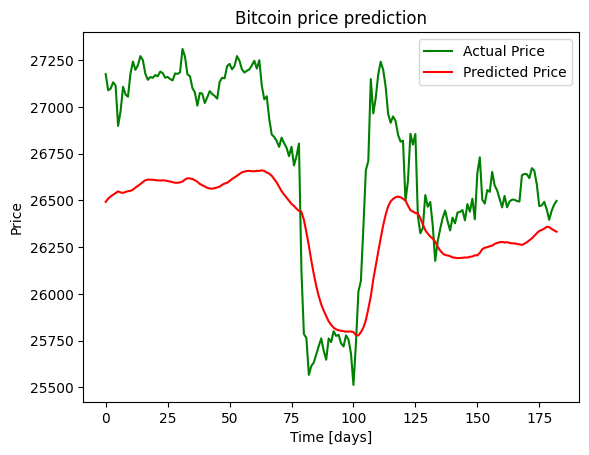

In [5]:
#   BTC PREDICTION

y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [37]:


#df = pd.DataFrame({'actual': y_test_inverse, 'predict': y_hat_inverse})
df1 = pd.DataFrame(y_hat_inverse)
df2 = pd.DataFrame(y_test_inverse)
result = pd.concat([df1, df2], axis=1)
result.columns = ['Predict', 'Actual']
result

,Predict,Actual
0,26492.283203,27174.710938
1,26509.398438,27088.357422
2,26521.021484,27097.388672
3,26530.044922,27131.419922
4,26539.753906,27114.099609
...,...,...
178,26358.960938,26452.828125
179,26357.238281,26396.167969
180,26347.267578,26444.554688
181,26339.929688,26477.042969


In [40]:
initial_capital = 100000
capital = initial_capital
position = None
profit_loss = 0
trades = []

for i in range(len(result) - 1):
    if position is None:
        if result['Predict'][i + 1] > result['Predict'][i]:
            position = 'long'
            entry_price = result['Actual'][i]
        else:
            position = 'short'
            entry_price = result['Actual'][i]

    if position == 'long' and result['Predict'][i + 1] < result['Predict'][i]:
        exit_price = result['Actual'][i + 1]
        trade_profit_loss = (exit_price - entry_price) / entry_price * capital
        trades.append((entry_price, exit_price, trade_profit_loss))
        profit_loss += trade_profit_loss
        position = None

    if position == 'short' and result['Predict'][i + 1] > result['Predict'][i]:
        exit_price = result['Actual'][i + 1]
        trade_profit_loss = (entry_price - exit_price) / entry_price * capital
        trades.append((entry_price, exit_price, trade_profit_loss))
        profit_loss += trade_profit_loss
        position = None

    capital += profit_loss

final_capital = capital
print(f"Final Capital: {final_capital} USD")

print("\nTrades:")
for trade in trades:
    entry_price, exit_price, trade_profit_loss = trade
    if trade_profit_loss > 0:
        trade_type = 'Long'
    else:
        trade_type = 'Short'
    print(f"{trade_type} Position: Entry Price: {entry_price:.2f} USD, Exit Price: {exit_price:.2f} USD, Profit/Loss: {trade_profit_loss:.2f} USD")


Final Capital: 256724.62064751127 USD

Trades:
Short Position: Entry Price: 27174.71 USD, Exit Price: 26975.63 USD, Profit/Loss: -732.60 USD
Short Position: Entry Price: 26975.63 USD, Exit Price: 27065.88 USD, Profit/Loss: -329.67 USD
Long Position: Entry Price: 27065.88 USD, Exit Price: 27159.40 USD, Profit/Loss: 303.74 USD
Short Position: Entry Price: 27159.40 USD, Exit Price: 27180.81 USD, Profit/Loss: -66.33 USD
Long Position: Entry Price: 27180.81 USD, Exit Price: 27176.06 USD, Profit/Loss: 13.85 USD
Short Position: Entry Price: 27176.06 USD, Exit Price: 27164.31 USD, Profit/Loss: -32.47 USD
Long Position: Entry Price: 27164.31 USD, Exit Price: 27057.97 USD, Profit/Loss: 261.03 USD
Long Position: Entry Price: 27057.97 USD, Exit Price: 27221.87 USD, Profit/Loss: 350.99 USD
Long Position: Entry Price: 27221.87 USD, Exit Price: 27204.66 USD, Profit/Loss: 36.35 USD
Short Position: Entry Price: 27204.66 USD, Exit Price: 27039.83 USD, Profit/Loss: -344.72 USD
Long Position: Entry Price: